In [1]:
%matplotlib inline 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import random 
from matplotlib import pyplot as plt 
import pylab 
pylab.rcParams['figure.figsize'] = (20, 15) 

#In case your Open CV version do not support SIFT
!pip install opencv-contrib-python==3.4.2.17

# Epipolar Geometry
 - **Part1:**
 find the matched points provided using SIFT and estimate the fundamental matrix F automatically using RANSAC and the normalized 8-point algorithm.

In [2]:
#Download the left and right perspective of site images 
!gdown --id '1RNCdBF9a4fIdcyPvjelyx7dsheLgRoaQ' --output leftSite.jpg
!gdown --id '1zHAtikO9dVHpLPJ-KQPdvKEC-wLB1hHM' --output rightSite.jpg

Downloading...
From: https://drive.google.com/uc?id=1RNCdBF9a4fIdcyPvjelyx7dsheLgRoaQ
To: /content/leftSite.jpg
100% 576k/576k [00:00<00:00, 81.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zHAtikO9dVHpLPJ-KQPdvKEC-wLB1hHM
To: /content/rightSite.jpg
100% 554k/554k [00:00<00:00, 70.4MB/s]


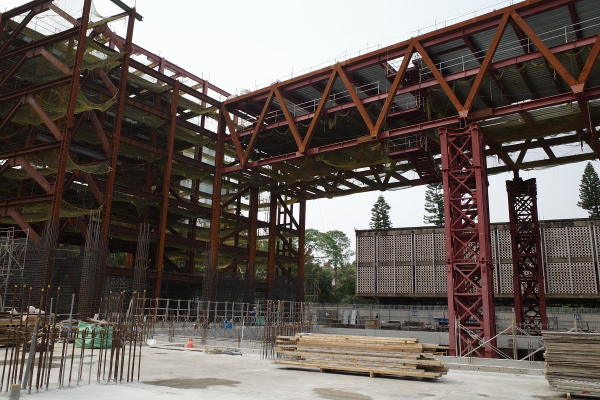

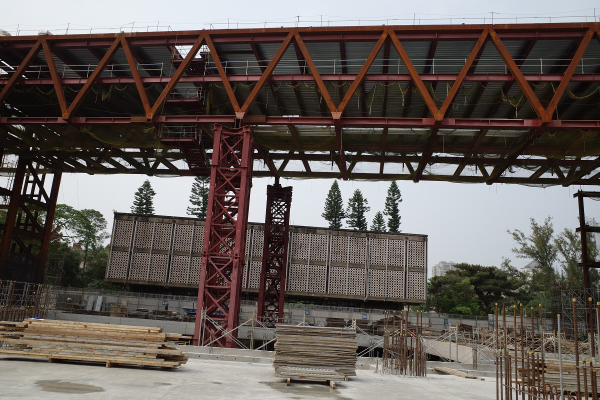

In [3]:
#Read the left and right perspective of site images 
img1_bgr = cv2.imread('leftSite.jpg')
img2_bgr  = cv2.imread('rightSite.jpg')

#Resize images for convenience
def resizeimg (img):
  img_resize = cv2.resize(img, (int(img.shape[1]*0.5),int(img.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
  return img_resize 

img1_bgr = resizeimg(img1_bgr)
img2_bgr = resizeimg(img2_bgr)

#display the images
cv2_imshow(img1_bgr)
cv2_imshow(img2_bgr)

In [5]:
# Converting images to gray scale
img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)

# create a SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# matching descriptor vectors with a FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

# Filter matches using the Lowe's ratio test
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [6]:
# estimate the fundamental matrix F automatically using RANSAC
F1, mask1 = cv2.findFundamentalMat(pts1,pts2,cv2.RANSAC, 5.0) 

# Display F1 after normalizing to unit length.
l1_norm = np.linalg.norm(F1, 1)
F1 /= l1_norm
print(F1)

[[-1.18453124e-06 -1.38199298e-05  4.32018058e-03]
 [ 1.61034079e-05 -2.22333878e-06 -3.57201836e-03]
 [-4.29930503e-03  4.61087781e-04  9.92107801e-01]]


In [7]:
# estimate the fundamental matrix F automatically using 8-point algorithm
F2, mask2 = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)

# Display F2 after normalizing to unit length.
l1_norm = np.linalg.norm(F2, 1)
F2 /= l1_norm
print(F2)

[[-3.34890805e-06  2.63096077e-05 -7.22470328e-03]
 [ 3.85514226e-06 -3.16814884e-06  1.79430978e-02]
 [ 1.85618505e-03 -2.31172300e-02  9.74832199e-01]]


In [ ]:
# Indicate what test you used for deciding inlier vs. outlier.
# select inlier points
pts1_inlier = pts1[mask1.ravel()==1]
pts2_inlier = pts2[mask1.ravel()==1]

# select outlier points
pts1_outlier = pts1[mask1.ravel()==0]
pts2_outlier = pts2[mask1.ravel()==0]

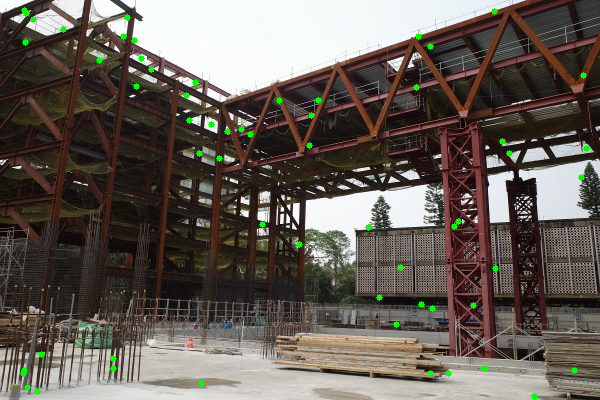

In [ ]:
# Plot the outliers with green dots on top of the first image
for x,y in pts1_outlier:
  cv2.circle(img1_bgr,(x,y), 3, (0, 255, 0), -1)  
cv2_imshow(img1_bgr)

 - **Part2:** Choose 7 sets of matching points that are well separated (can be randomly chosen). 
Plot the corresponding epipolar lines and the points on each image. 
Show the two images (with plotted points and lines) next to each other. 

In [ ]:
# Choose 7 sets of matching points that are well separated (can be randomly chosen)
def random_matches(pts1, pts2):
  c = list(zip(pts1,pts2))
  se = random.sample(c, 7)
  se_pts1 = np.array([a for (a, b) in se])
  se_pts2 = np.array([b for (a, b) in se]) 
  return se_pts1, se_pts2
                            

selected = random_matches(pts1_inlier, pts2_inlier)
# 7 sets of matching points in img1
selected_pts1 = selected[0] 
# 7 sets of matching points in img2
selected_pts2 = selected[1]

In [ ]:
# This method computes and draws the epipolar lines and matching points of the two loaded images.
def drawlines(img1, img2, lines, pts1, pts2, colors):
    r, c = img1.shape

    # Converting images from gray scale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

    for r, pt1, pt2, color in zip(lines, pts1, pts2, colors):

        # calculate start and end point of each epiline
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])

        # draw each epiline and its matching points
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 2)
        img1 = cv2.circle(img1, tuple(pt1), 6, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 6, color, -1)

    return img1, img2

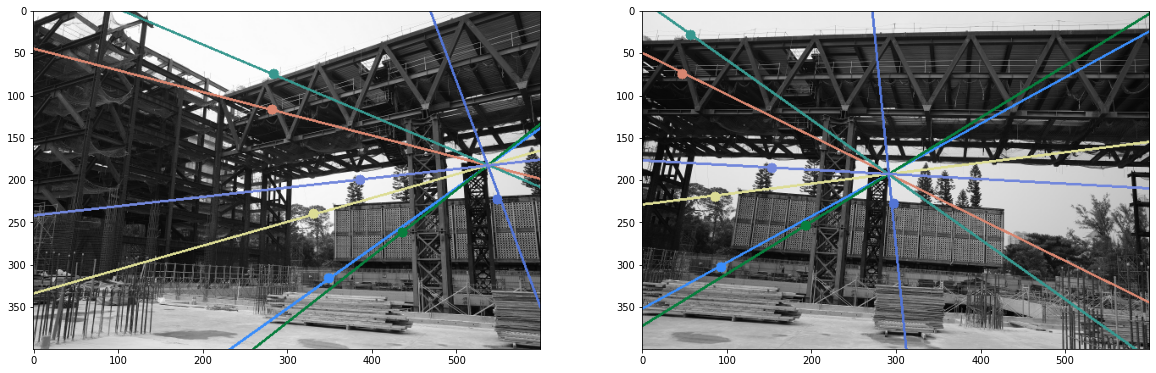

In [ ]:
# Create 7 random colors 
colors = []
for i in range(7):
  colors.append(tuple(np.random.randint(0, 255, 3).tolist()))

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(selected_pts2.reshape(-1,1,2), 2, F1)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, selected_pts1, selected_pts2, colors)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(selected_pts1.reshape(-1,1,2), 1, F1)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, selected_pts2, selected_pts1, colors)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()